In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_fashion')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
del y_train
del y_test
del mndata
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).reshape(-1,28,28,1)

In [4]:
import sys
sys.path.append("../dnn_from_scratch")

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 931
Seed: 386


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((7,7,128)))
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
5 con

In [7]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,1)))
#     model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
#     model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.2))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 14, 14, 32)         leakyRelu        320
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 14, 14, 32)         echo             128
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
5 BatchN

In [8]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [9]:
noise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(noise)

In [10]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen.reshape(28,28)+1)/2, cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

In [11]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size*2,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size*2,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%60:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).sum(),time()-stt),end='')

EPOCH: 1 / 5


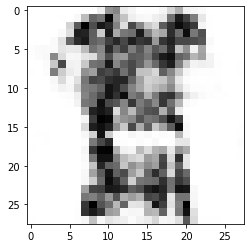

[9.81874e-06]
Progress: 5.39 %     Dloss: 24.986751556396484    err: 1711.35595703125     Sample time: 1.953s    ___

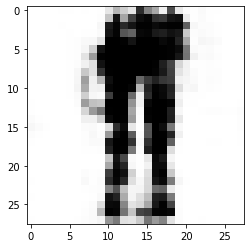

[2.709937e-06]
Progress: 10.88 %     Dloss: 32.14125061035156    err: 1662.2333984375     Sample time: 2.062s    _ _ _

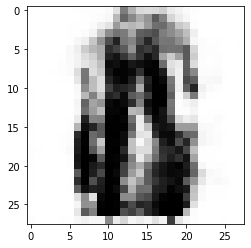

[0.00093694]
Progress: 16.37 %     Dloss: 35.56920623779297    err: 1578.613525390625     Sample time: 2.418s    _ _

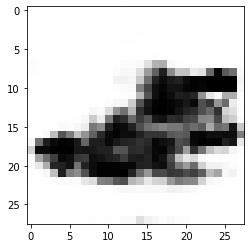

[5.929053e-05]
Progress: 21.85 %     Dloss: 39.07095718383789    err: 1787.9814453125     Sample time: 2.545s    _  __

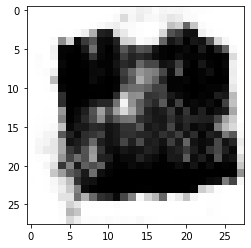

[0.14721422]
Progress: 27.34 %     Dloss: 37.75532531738281    err: 1625.1971435546875     Sample time: 2.498s    __

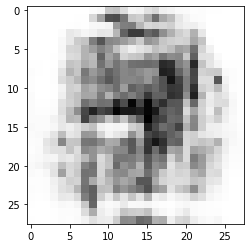

[0.08773286]
Progress: 32.82 %     Dloss: 26.690921783447266    err: 1539.84033203125     Sample time: 2.444s    _ _

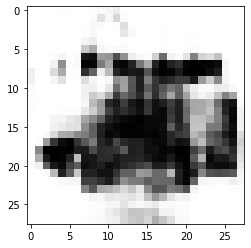

[0.08689149]
Progress: 38.31 %     Dloss: 29.643299102783203    err: 1924.337158203125     Sample time: 2.396s    __

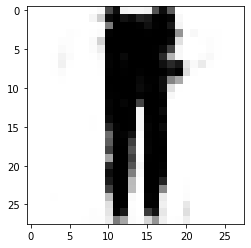

[3.127002e-07]
Progress: 43.79 %     Dloss: 29.29827880859375    err: 1748.200439453125     Sample time: 2.352s    ___

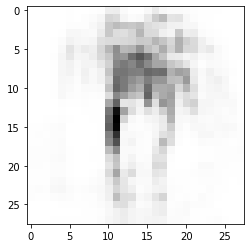

[8.381337e-05]
Progress: 49.28 %     Dloss: 24.546993255615234    err: 1677.7711181640625     Sample time: 2.440s    _

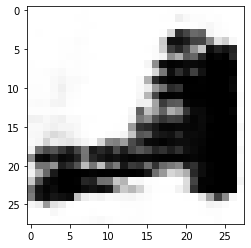

[0.01601147]
Progress: 54.77 %     Dloss: 31.473215103149414    err: 1662.4886474609375     Sample time: 2.505s    _

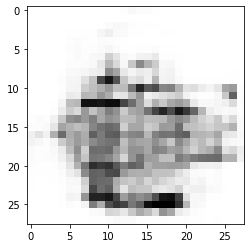

[0.0356284]
Progress: 60.25 %     Dloss: 40.28062057495117    err: 1596.8243408203125     Sample time: 2.045s    __

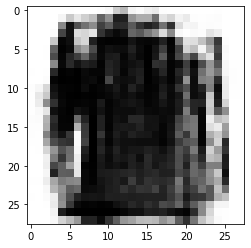

[0.75382173]
Progress: 65.74 %     Dloss: 28.602558135986328    err: 1804.0906982421875     Sample time: 2.104s    _

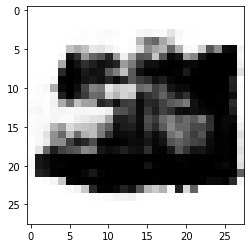

[0.03989598]
Progress: 71.22 %     Dloss: 28.201173782348633    err: 1634.7845458984375     Sample time: 2.035s    _

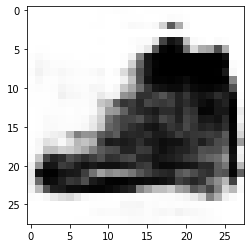

[0.2861896]
Progress: 76.71 %     Dloss: 36.02178192138672    err: 1645.455078125     Sample time: 2.114s    _   __

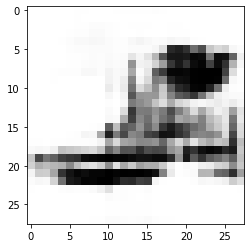

[0.12120251]
Progress: 82.19 %     Dloss: 27.207313537597656    err: 1639.3275146484375     Sample time: 2.101s    _

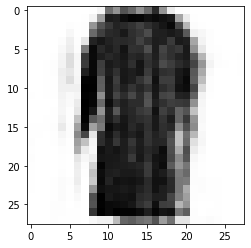

[0.07743727]
Progress: 87.68 %     Dloss: 27.5098876953125    err: 1876.3370361328125     Sample time: 2.082s    ___

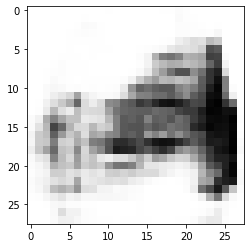

[0.03225631]
Progress: 93.17 %     Dloss: 33.09467315673828    err: 1709.870849609375     Sample time: 2.070s    ___

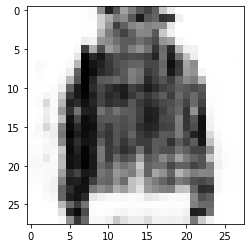

[0.47413394]
Progress: 98.65 %     Dloss: 36.37388610839844    err: 1762.6920166015625     Sample time: 2.026s    __

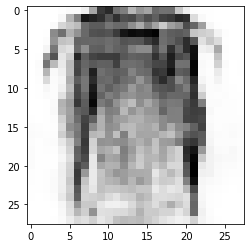

[0.8689129]
Progress: 99.84 %     Dloss: 38.376373291015625    err: 1675.13134765625     Sample time: 2.256s    _ _
Epoch time: 41:51s


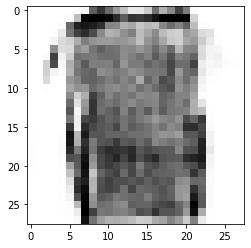

[0.71601045]
EPOCH: 2 / 5


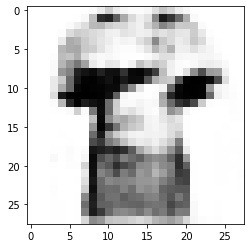

[0.1367804]
Progress: 5.39 %     Dloss: 28.362462997436523    err: 1715.198974609375     Sample time: 2.106s    __

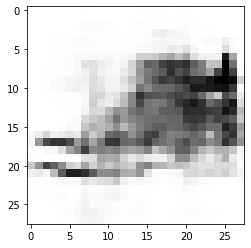

[0.28106442]
Progress: 10.88 %     Dloss: 44.637874603271484    err: 1722.4140625     Sample time: 2.048s    _    __

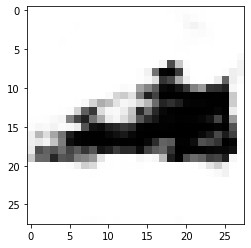

[0.00023356]
Progress: 16.37 %     Dloss: 28.659351348876953    err: 1802.553466796875     Sample time: 2.141s    __

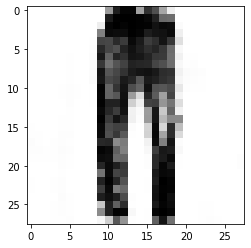

[0.54784507]
Progress: 21.85 %     Dloss: 26.440715789794922    err: 1786.465087890625     Sample time: 2.161s    __

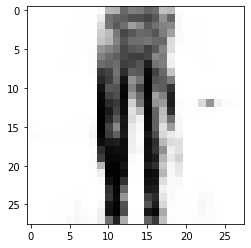

[0.0033461]
Progress: 27.34 %     Dloss: 28.629383087158203    err: 1904.775390625     Sample time: 2.054s    _  __

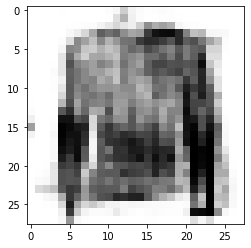

[0.31404066]
Progress: 32.82 %     Dloss: 24.12725257873535    err: 1811.6417236328125     Sample time: 2.104s    __

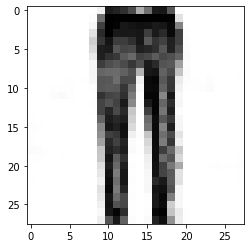

[0.9501876]
Progress: 38.31 %     Dloss: 29.87194061279297    err: 1734.00146484375     Sample time: 2.019s    _ __

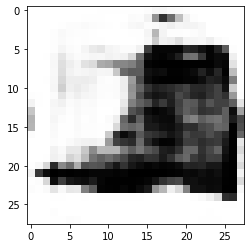

[0.00030717]
Progress: 43.79 %     Dloss: 25.390438079833984    err: 1980.370361328125     Sample time: 2.086s    __

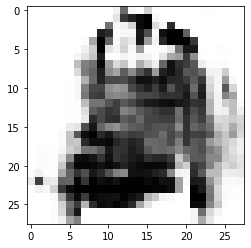

[0.09209063]
Progress: 49.28 %     Dloss: 28.221656799316406    err: 1952.5673828125     Sample time: 2.009s    _ __

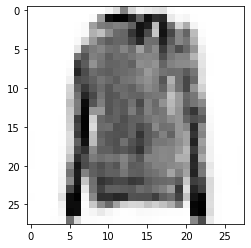

[0.00230311]
Progress: 54.77 %     Dloss: 32.14250183105469    err: 1870.1324462890625     Sample time: 2.141s    __

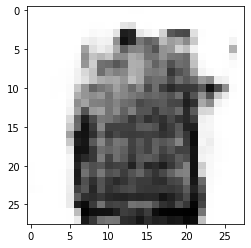

[0.00044865]
Progress: 60.25 %     Dloss: 47.89808654785156    err: 1792.81201171875     Sample time: 2.172s    _  _

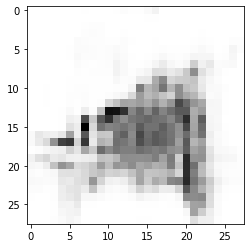

[0.00030498]
Progress: 65.74 %     Dloss: 32.66864013671875    err: 1530.8499755859375     Sample time: 2.030s    __

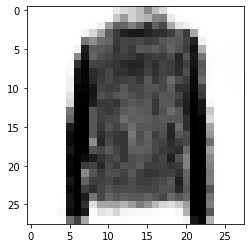

[0.24072623]
Progress: 71.22 %     Dloss: 29.560504913330078    err: 1912.1396484375     Sample time: 2.007s    _  _

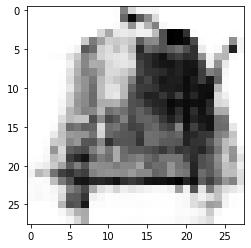

[0.03573134]
Progress: 76.71 %     Dloss: 39.452178955078125    err: 1828.1431884765625     Sample time: 2.037s    _

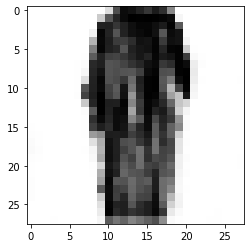

[7.557181e-05]
Progress: 82.19 %     Dloss: 40.149574279785156    err: 1675.8306884765625     Sample time: 2.028s    _

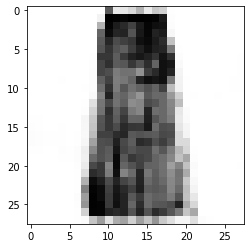

[0.03158555]
Progress: 87.68 %     Dloss: 38.151466369628906    err: 1835.982421875     Sample time: 2.035s    _  __

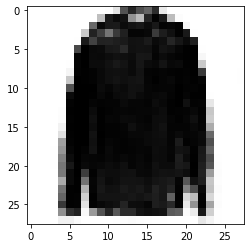

[0.7305392]
Progress: 93.17 %     Dloss: 34.8564453125    err: 2076.8671875     Sample time: 2.052s    _030s    _ _

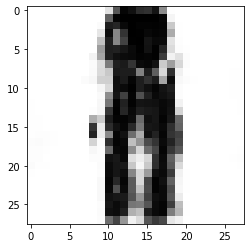

[0.01426193]
Progress: 98.65 %     Dloss: 41.333106994628906    err: 1574.6763916015625     Sample time: 2.011s    _

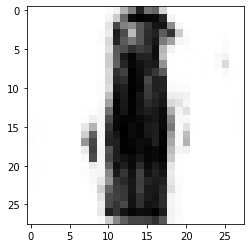

[0.23055008]
Progress: 99.84 %     Dloss: 34.021385192871094    err: 1704.0677490234375     Sample time: 2.037s    _
Epoch time: 37:49s


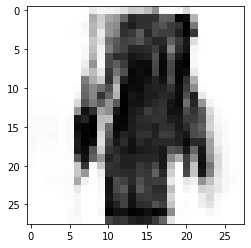

[0.6866019]
EPOCH: 3 / 5


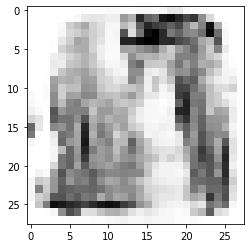

[0.02358049]
Progress: 5.39 %     Dloss: 31.55986976623535    err: 1719.3502197265625     Sample time: 2.012s    __

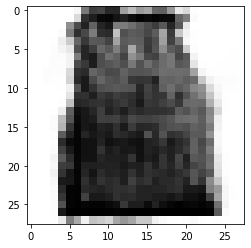

[0.1405547]
Progress: 10.88 %     Dloss: 33.079010009765625    err: 2013.1641845703125     Sample time: 2.023s    _

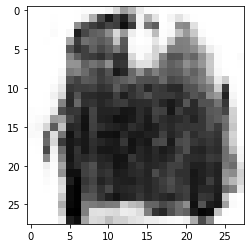

[0.5865034]
Progress: 16.37 %     Dloss: 33.63140869140625    err: 1835.9765625     Sample time: 2.177s    _1s    _

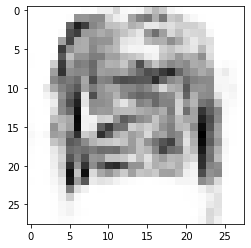

[0.01664749]
Progress: 21.85 %     Dloss: 26.311473846435547    err: 1777.0726318359375     Sample time: 2.060s    _

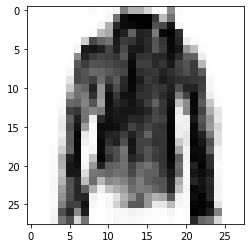

[0.03504528]
Progress: 27.34 %     Dloss: 37.447261810302734    err: 1658.54150390625     Sample time: 2.073s    ___

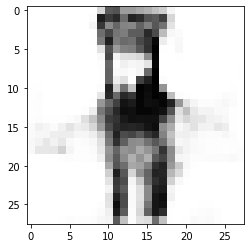

[0.20575388]
Progress: 32.82 %     Dloss: 28.698482513427734    err: 1955.880615234375     Sample time: 2.114s    __

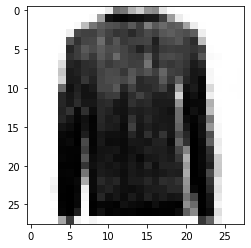

[0.00865518]
Progress: 38.31 %     Dloss: 34.22503662109375    err: 1550.2674560546875     Sample time: 2.048s    __

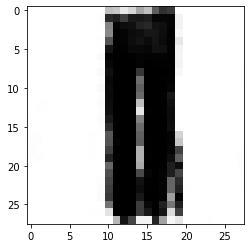

[0.05803391]
Progress: 43.79 %     Dloss: 36.66870880126953    err: 1881.0997314453125     Sample time: 2.037s    __

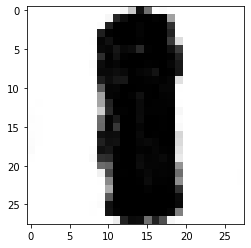

[6.493074e-06]
Progress: 49.28 %     Dloss: 31.652667999267578    err: 1804.560546875     Sample time: 2.054s    _ ___

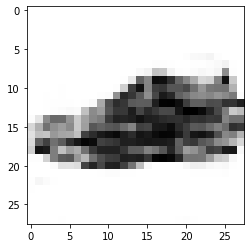

[0.00853803]
Progress: 54.77 %     Dloss: 34.9212646484375    err: 1846.613525390625     Sample time: 2.033s    ____

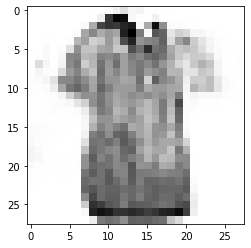

[0.52383125]
Progress: 60.25 %     Dloss: 30.0858211517334    err: 1955.023681640625     Sample time: 2.064s    ____

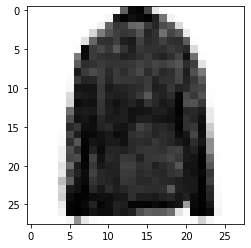

[0.43076903]
Progress: 65.74 %     Dloss: 41.533485412597656    err: 1786.0428466796875     Sample time: 2.040s    _

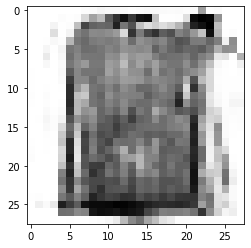

[0.75239265]
Progress: 71.22 %     Dloss: 29.57529640197754    err: 1939.437255859375     Sample time: 2.040s    _ _

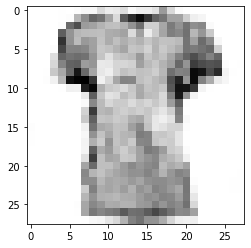

[0.38944823]
Progress: 76.71 %     Dloss: 33.74912643432617    err: 1795.691650390625     Sample time: 2.035s    ___

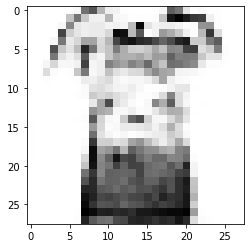

[0.00613027]
Progress: 82.19 %     Dloss: 30.99148941040039    err: 1829.9881591796875     Sample time: 2.117s    __

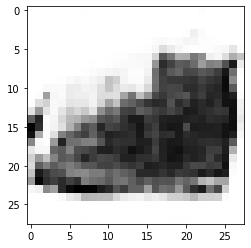

[0.35026222]
Progress: 87.68 %     Dloss: 38.5984992980957    err: 1835.039306640625     Sample time: 2.036s    _ __

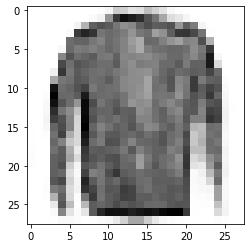

[0.21060285]
Progress: 93.17 %     Dloss: 32.3372802734375    err: 1905.1307373046875     Sample time: 2.028s    _ _

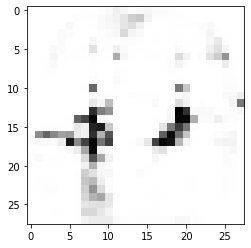

[0.00386392]
Progress: 98.65 %     Dloss: 30.876449584960938    err: 2024.3173828125     Sample time: 2.074s    _  _

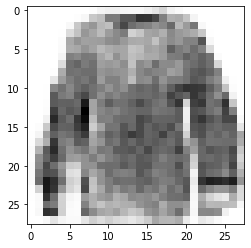

[0.02429258]
Progress: 99.84 %     Dloss: 29.158458709716797    err: 2070.444580078125     Sample time: 2.062s    __
Epoch time: 37:49s


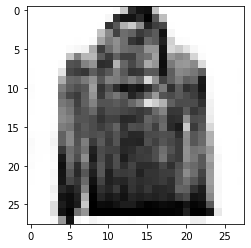

[0.1330592]
EPOCH: 4 / 5


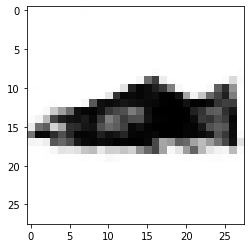

[0.01736399]
Progress: 5.39 %     Dloss: 31.321426391601562    err: 1789.3472900390625     Sample time: 2.111s    _

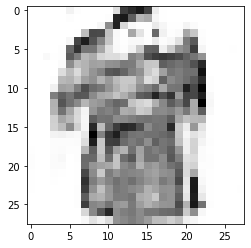

[0.4420215]
Progress: 10.88 %     Dloss: 41.208839416503906    err: 1637.49072265625     Sample time: 2.038s    ___

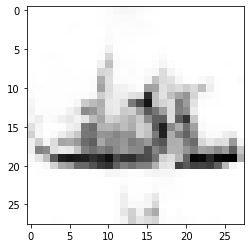

[0.23237358]
Progress: 16.37 %     Dloss: 43.293434143066406    err: 1588.4537353515625     Sample time: 2.041s    _

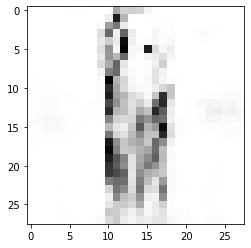

[0.23883496]
Progress: 21.85 %     Dloss: 38.709190368652344    err: 1976.03955078125     Sample time: 2.099s    ___

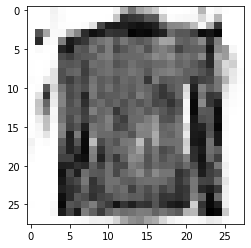

[0.54368806]
Progress: 27.34 %     Dloss: 30.826770782470703    err: 1956.5799560546875     Sample time: 2.275s    _

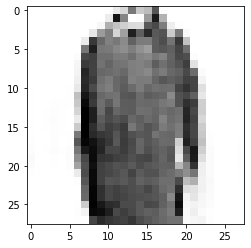

[0.24849027]
Progress: 32.82 %     Dloss: 31.440858840942383    err: 1834.6317138671875     Sample time: 2.035s    _

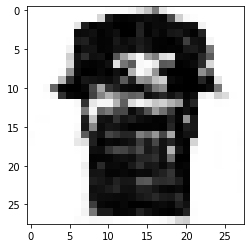

[0.9198745]
Progress: 38.31 %     Dloss: 29.441299438476562    err: 1771.9779052734375     Sample time: 2.139s    _

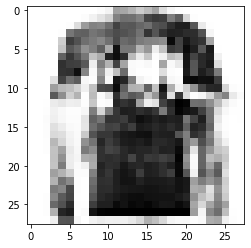

[0.22884165]
Progress: 43.79 %     Dloss: 33.74702453613281    err: 1881.059326171875     Sample time: 2.122s    ___

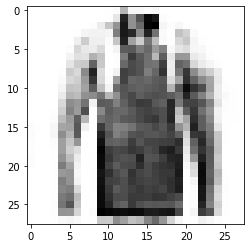

[0.04564945]
Progress: 49.28 %     Dloss: 24.274959564208984    err: 2015.4892578125     Sample time: 2.087s    ____

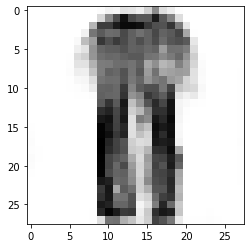

[0.02749521]
Progress: 54.77 %     Dloss: 39.461769104003906    err: 1780.8421630859375     Sample time: 2.135s    _

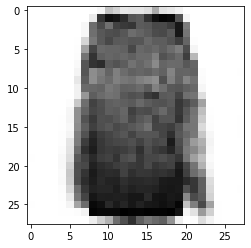

[0.02770682]
Progress: 60.25 %     Dloss: 30.850116729736328    err: 1742.163818359375     Sample time: 2.042s    __

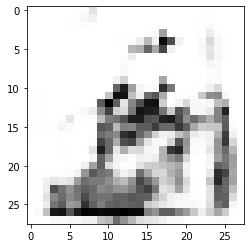

[0.16445881]
Progress: 65.74 %     Dloss: 38.2052001953125    err: 1638.17724609375     Sample time: 2.032s    _ _ _

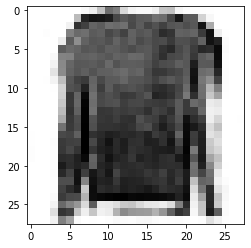

[0.01602259]
Progress: 71.22 %     Dloss: 25.788421630859375    err: 1780.8511962890625     Sample time: 2.029s    _

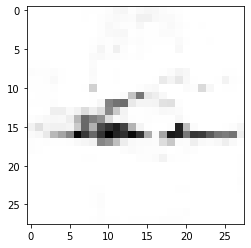

[0.5851063]
Progress: 76.71 %     Dloss: 43.29610061645508    err: 1920.439697265625     Sample time: 2.037s    ___

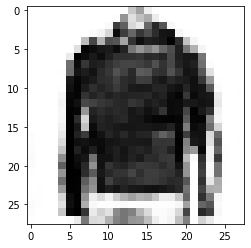

[0.15014169]
Progress: 82.19 %     Dloss: 42.168949127197266    err: 1797.4969482421875     Sample time: 2.102s    _

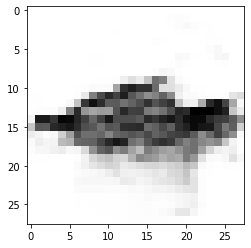

[0.12043201]
Progress: 87.68 %     Dloss: 36.899810791015625    err: 1905.84033203125     Sample time: 2.022s    ___

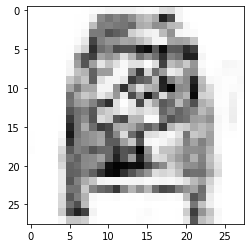

[0.40652585]
Progress: 93.17 %     Dloss: 40.32594680786133    err: 1840.5867919921875     Sample time: 2.190s    __

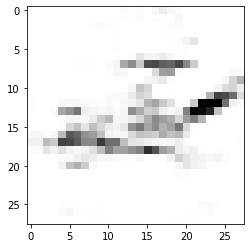

[0.06108306]
Progress: 98.65 %     Dloss: 47.02758026123047    err: 1876.5179443359375     Sample time: 2.014s    __

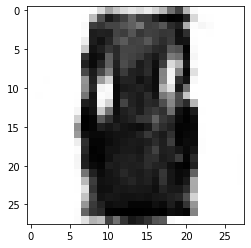

[0.06062794]
Progress: 99.84 %     Dloss: 40.79930114746094    err: 1707.313720703125     Sample time: 2.069s    _ _
Epoch time: 37:46s


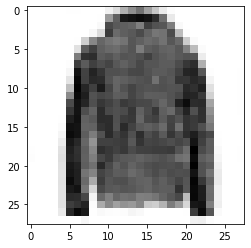

[0.4707878]
EPOCH: 5 / 5


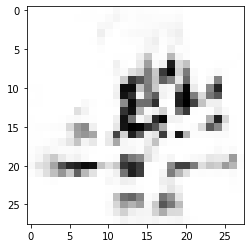

[0.73476607]
Progress: 5.39 %     Dloss: 35.23624038696289    err: 1771.97705078125     Sample time: 2.076s    __ _

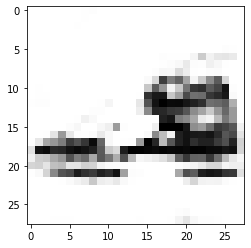

[0.02002115]
Progress: 10.88 %     Dloss: 38.87458801269531    err: 1993.6912841796875     Sample time: 2.037s    __

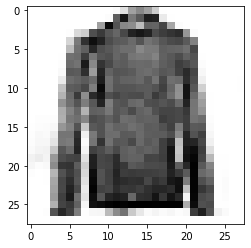

[0.18178461]
Progress: 16.37 %     Dloss: 37.45952224731445    err: 1724.62890625     Sample time: 2.099s    _  _  _

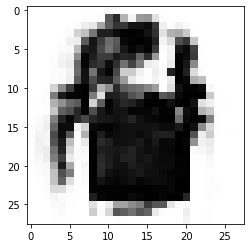

[0.13751502]
Progress: 21.85 %     Dloss: 33.10639190673828    err: 1734.8272705078125     Sample time: 2.063s    __

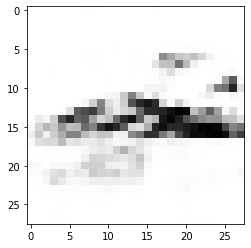

[0.2869167]
Progress: 27.34 %     Dloss: 33.68183898925781    err: 1616.2093505859375     Sample time: 2.027s    __

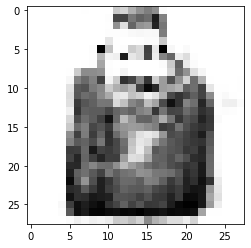

[0.3266896]
Progress: 32.82 %     Dloss: 31.91098976135254    err: 1716.29638671875     Sample time: 2.034s    _  _

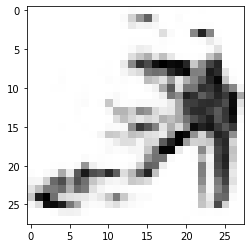

[0.5159606]
Progress: 38.31 %     Dloss: 30.82377815246582    err: 1667.99658203125     Sample time: 2.040s    _ __

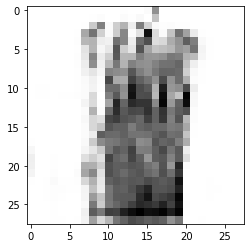

[0.58778554]
Progress: 43.79 %     Dloss: 29.93794822692871    err: 1791.3748779296875     Sample time: 2.050s    __

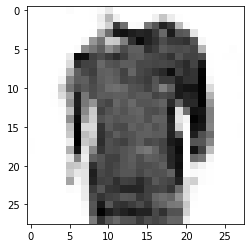

[0.00962156]
Progress: 49.28 %     Dloss: 34.52979278564453    err: 1786.569580078125     Sample time: 2.049s    _ _

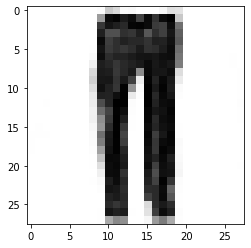

[0.86313933]
Progress: 54.77 %     Dloss: 31.567302703857422    err: 1708.405029296875     Sample time: 2.134s    __

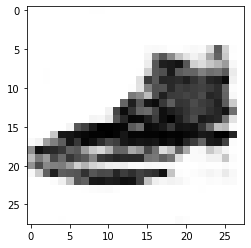

[0.16387805]
Progress: 60.25 %     Dloss: 34.83716583251953    err: 1687.7225341796875     Sample time: 2.019s    __

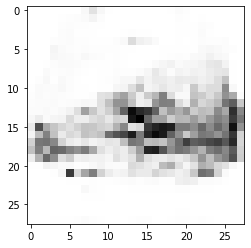

[0.15339024]
Progress: 65.74 %     Dloss: 33.89825439453125    err: 1601.638671875     Sample time: 2.095s    _   __

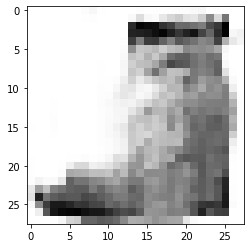

[0.71639663]
Progress: 71.22 %     Dloss: 27.990127563476562    err: 1869.2967529296875     Sample time: 2.022s    _

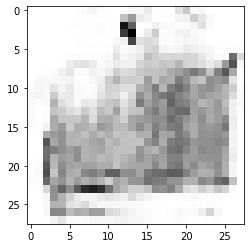

[0.19165246]
Progress: 76.71 %     Dloss: 33.0362663269043    err: 1795.3670654296875     Sample time: 2.118s    ___

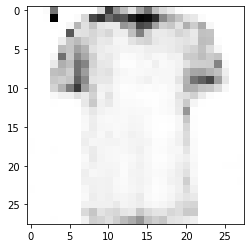

[4.8576112e-05]
Progress: 82.19 %     Dloss: 37.61705017089844    err: 1760.245361328125     Sample time: 2.040s    ___

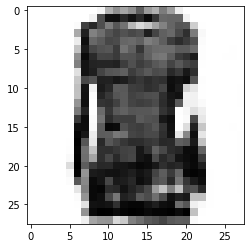

[0.0067188]
Progress: 87.68 %     Dloss: 32.81965255737305    err: 1701.6817626953125     Sample time: 2.043s    __

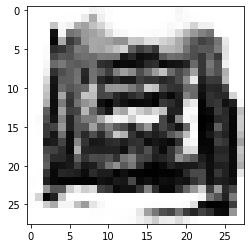

[0.86533725]
Progress: 93.17 %     Dloss: 37.20458221435547    err: 1785.1251220703125     Sample time: 2.051s    __

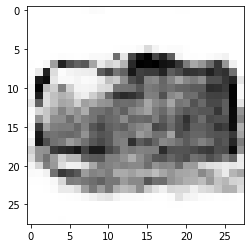

[0.00081811]
Progress: 98.65 %     Dloss: 32.018898010253906    err: 1855.1878662109375     Sample time: 1.896s    _

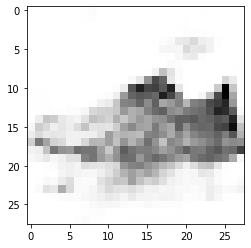

[0.2932612]
Progress: 99.84 %     Dloss: 35.50801467895508    err: 1915.438720703125     Sample time: 1.902s    ___
Epoch time: 37:25s


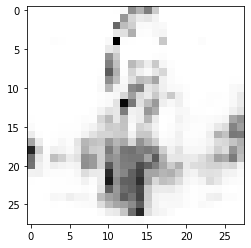

[0.18077198]


In [26]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

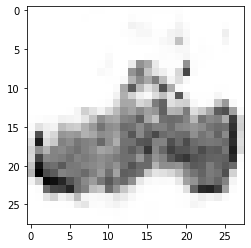

[0.17942853]


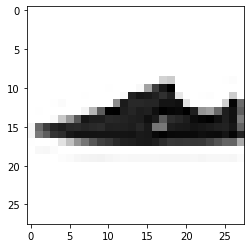

[[0.6540118]]


In [27]:
noise=np.random.randn(128,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img.reshape(28,28)+1)/2, cmap='Greys')
plt.show()
print(d.predict(img))

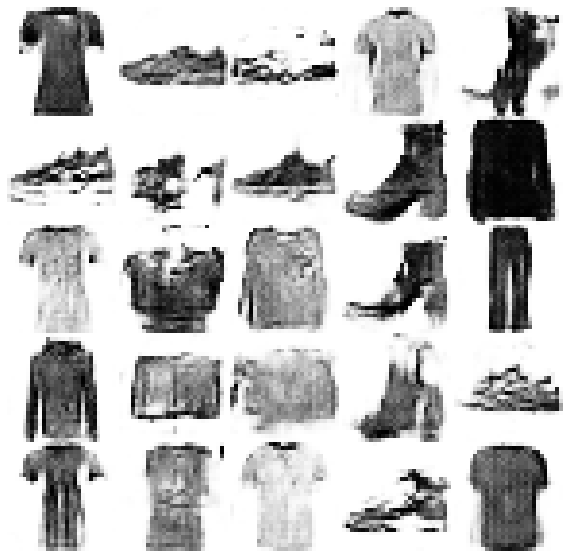

In [28]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    axi.imshow((gen[i].squeeze()+1)/2, cmap='Greys')

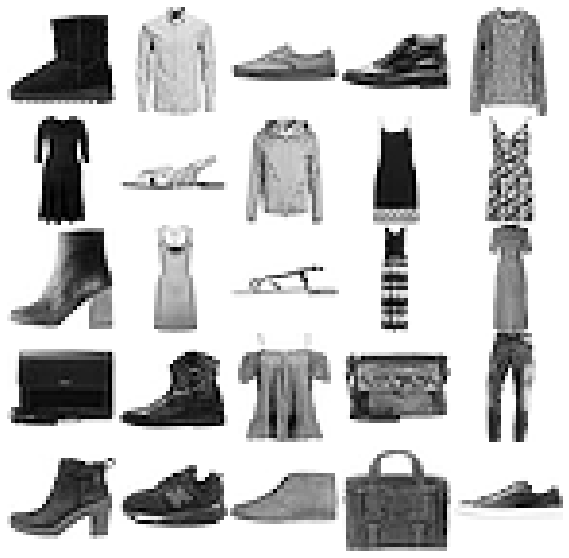

In [15]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
gen=X_train[np.random.randint(low=0,high=X_train.shape[0],size=25)]
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    axi.imshow((gen[i].squeeze()+1)/2, cmap='Greys')